# Load Data
description : 
    1. data set preprocessing 
    2. drop non-realated columns
    3. 

In [1]:
from sklearn.impute import KNNImputer
import numpy as np
import pandas as pd
import csv
import random
import matplotlib.pyplot as plt
from scipy.spatial import distance
np.set_printoptions(precision=3)


#open csv file 
df = pd.read_csv("real_estate_valuation_dataset.csv")

df = df.drop(['No','X1 transaction date','X5 latitude','X6 longitude'], axis=1)

    
# dict = {'First':  [70, 100, 90, np.nan, 95, 40, 53, 88, 15, 20], 
#         'Second': [20, 30, 45, 56, np.nan, 10, np.nan, 32, 9, 7], 
#         'Third':  [np.nan, np.nan, 40, 80, 98, 70, 21, 43, 12, 33],
#         'Fourth': [64, 20, 54, 90, 70, 81, 22, 10, 70, 4],
#         'Fifth':  [np.nan, np.nan, 74, np.nan, 10, 51, 17, 23, 87, 19],
#         'Sixth':  [82, np.nan,5,20,np.nan, np.nan,np.nan, 50, 4, 11]
#        }

# dict = { 'First':   [4, 8, 3, 6, 0, 5], 
#           'Second': [7, 2, 4, 8, 3, 7], 
#           'Third':  [3, 5, 4, 5, 7, 5]
#        }

print(df)

#take mean of k-nearest neigbors, 
#if k > number of all rows then k = # of rows
imputer = KNNImputer(n_neighbors = 4)
df_filled = imputer.fit_transform(df)
# print(df_filled)

     X2 house age  X3 distance to the nearest MRT station  \
0            32.0                                84.87882   
1            19.5                               306.59470   
2            13.3                               561.98450   
3            13.3                               561.98450   
4             5.0                               390.56840   
..            ...                                     ...   
409          13.7                              4082.01500   
410           5.6                                90.45606   
411          18.8                               390.96960   
412           8.1                               104.81010   
413           6.5                                90.45606   

     X4 number of convenience stores  Y house price of unit area  
0                                 10                        37.9  
1                                  9                        42.2  
2                                  5                        47.3  

In [2]:
def dominate(v1, v2):
    
    dom = False
    for d in range(len(v1)):        
        if(d == 1):
            if(v1[d] <= v2[d]):
                dom = True
            else:
                dom = False
                break
        elif(d == 0 or d == 2 or d == 3):
            if(v1[d] >= v2[d]):
                dom = True
            else:
                dom = False
                break
    
    return dom
    

def findskyline(array):
    rows, cols = array.shape
#     print("row of array = ", rows)
#     print("col of array = ", cols)
    
    skylineList = [0]
    candidate = []
    for row in range(rows):
#         print("iteration : ", row)
        new = array[row]
        length = len(skylineList)
        
        for index in range(length):
            temp = skylineList.pop(0)
#             print("pop out element : "+str(temp))
            pop = array[temp]
            
            if(not(dominate(new, pop)) and not(dominate(pop, new))):
#                 print(str(new)+ " and "+ str(pop) + " don't dominate each other.")
                if(index == (length-1) ):
#                     print("last index:" + str(index))
#                     print("insert " + str(row) + " into candidate." )    
                    if(row not in candidate):
                        candidate.append(row)
                
#                 print("insert " + str(temp) + " into candidate." )    
                if(temp not in candidate):
                    candidate.append(temp)
            
            elif(dominate(new, pop)):
#                 print(str(new) + " dominate " + str(pop))
#                 print("insert " + str(row) + " into candidate." )
                if(row not in candidate):
                    candidate.append(row)
            
            elif(dominate(pop, new)):
#                 print(str(pop) + " dominate " + str(new))
#                 print("insert " + str(temp) + " into candidate." )
                if(temp not in candidate):
                    candidate.append(temp)
            
#             print("candidate : "+str(candidate))
        
        skylineList = candidate[:]
        candidate.clear()
            
#         print("current skylineList:"+str(skylineList))

    return skylineList

def printAllItemN(ndarray):
    for item in ndarray:
        print(item)


def assignMissValue(n, mR):
    missArray = n.copy()
    cols = len(missArray[0])
    rows = len(missArray)
    miss = 0
    origin = 0
    
    for col in range(cols):
        for row in range(rows):
            r = random.random()
            if r < mR:
                #then determine to miss
                missArray[row][col] = np.nan
#                 print("assign miss")
                miss += 1
            elif r >= mR:
                #remain origin value
#                 print("origin value")
                origin +=1
#         print("miss count : ", miss)
#         print("miss rate = ", (miss/rows))
#         print("origin count : ", origin)
#         print("origin rate = ", (origin/rows))
        miss = 0
        origin = 0
    
#     printAllItemN(missArray)
    return missArray


def difference2Lists(sky_list, est_list):
    set_difference = set(sky_list) - set(est_list)
    list_difference = list(set_difference)
    
    return list_difference

def returnHitList(sky_list, est_list):
    set1 = set(sky_list)
    set2 = set(est_list)
    hitSet = set1.intersection(set2)
    
    return list(hitSet)

def returnMissList(sky_list, est_list):
    set1 = set(sky_list)
    set2 = set(est_list)
    missSet = set1.union(set2) - set1.intersection(set2)
    
    return list(missSet)

def hitRatio(sky_list, est_list):
    set1 = set(sky_list)
    set2 = set(est_list)
    union2Set = set1.union(set2)
    hitSet = set(returnHitList(sky_list, est_list))
    return len(hitSet)/len(union2Set)

def missRatio(sky_list, est_list):
    return 1-hitRatio(sky_list, est_list)


In [3]:
list1 = [1,2,3,5]
list2 = [5,1,7,4]

# print(distance.euclidean(list1,list2,None)) #length must be equal
# print(distance.hamming(list1,list2,None)) #length must be equal

'''
    new metrics to benchmark the diatance between est_skyline and origin_skyline 
'''

def HammingHit(list1, list2):
    hit = 0
    for item in list1:
        if item in list2:
            hit +=1
    
    return hit

def skyline_HammingDistance(list1, list2):
    hit = HammingHit(list1, list2)
    set1 = set(list1)
    set2 = set(list2)
    union = set1.union(set2)
#     print(union)
    distance = hit/len(list(union))
    
    return distance

# print(skyline_HammingDistance(list1,list2))
# print(skyline_HammingDistance(list2,list1))
# print(skyline_HammingDistance(list1,list1))

def nanCountAtCol(array, column):
    rows = len(array)
#     cols = len(array[0])
    nanCount = 0
    for row in range(rows):
        if np.isnan(array[row][column]):
            nanCount += 1
#             print("array [",row,"][",column,"] is nan value")
#             print(array[row][column])
    
    return nanCount

def setK(array, col, k):
    K_in_col = k
    n = len(array)
    missCount = nanCountAtCol(array, col)
    
    if K_in_col >= (n - missCount):
        K_in_col = (n - missCount)
    elif K_in_col > 0 and K_in_col < (n - missCount) :
        K_in_col = k
    else:
        print("Invalid value of K_in_col in setK function!")
    
    return K_in_col

def resetNanCells(array):
    reset_array = array.copy()
    rows = len(array)
    cols = len(array[0])
    
    for row in range(rows):
        for col in range(cols):
            if np.isnan(reset_array[row][col]):
                reset_array[row][col] = 0
    
#     print(reset_array)
    return reset_array

original skyline set 
[220, 389, 70, 128, 275, 160, 299, 67, 74, 413, 163, 361, 192, 172, 233, 222, 312, 236, 270, 326, 360, 318, 363, 385, 377, 379, 381, 390, 392, 395, 396, 403, 404, 411, 412, 0]
original skyline length = 36
k =  1


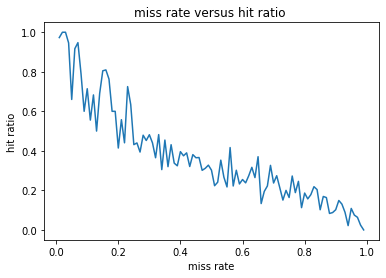

k =  2


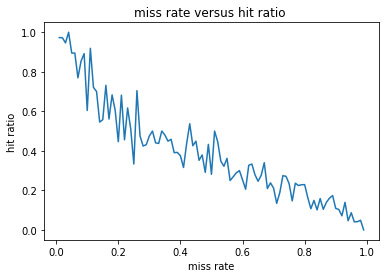

k =  3


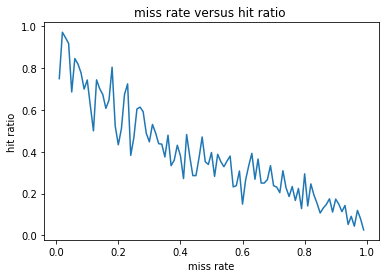

k =  4


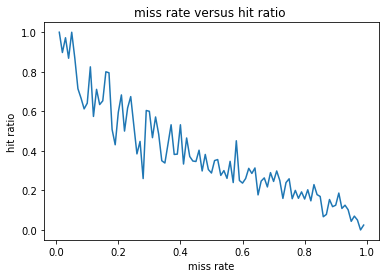

In [4]:
# print(type(df_filled))

original_skyline = findskyline(df_filled)
print("original skyline set ")
print(original_skyline)
print("original skyline length = " + str(len(original_skyline)))

for i in range(1,len(df_filled[0])+1):
    imputer = KNNImputer(n_neighbors = i) 
    print("k = ",i)
    miss_rate = []
    hit_ratio = []
    for missRate in [float(j) / 100 for j in range(1, 100, 1)]:
#         print("missing rate : ",missRate)

        after_miss = assignMissValue(df_filled, missRate)
    #     print("missing data set ")
    #     print(after_miss)
    #     print("after imputation : ")

        miss_filled = imputer.fit_transform(after_miss)
    #     print(miss_filled)

        est_skyline = findskyline(miss_filled)
    #     print("estimated skyline set ")
    #     print(est_skyline)
    #     print("estimated skyline length = " + str(len(est_skyline)))

#         print("Hit Ratio of : ",hitRatio(original_skyline,est_skyline2))
        miss_rate.append(missRate)
        hit_ratio.append(hitRatio(original_skyline,est_skyline))
#         print(skyline_HammingDistance(original_skyline,est_skyline))
        
    plt.title("miss rate versus hit ratio ") # title
    plt.xlabel("miss rate") # x label
    plt.ylabel("hit ratio") # y label
    plt.plot(miss_rate, hit_ratio) #(x-axis, y-axis)
    plt.show()

In [5]:

imputer3 = KNNImputer(n_neighbors = 3)
df_filled = imputer3.fit_transform(df_filled)
missRate = 0.5

after_miss = assignMissValue(df_filled, missRate)
imputer = KNNImputer(n_neighbors = 3, weights = 'distance')
k1 = imputer.fit_transform(after_miss)
imputer2 = KNNImputer(n_neighbors = 3, weights = 'uniform')
k2 = imputer2.fit_transform(after_miss)


original_skyline = findskyline(df_filled)
weighted_skyline = findskyline(k1)
uniform_skyline  = findskyline(k2)

print(hitRatio(original_skyline, weighted_skyline))

print(hitRatio(original_skyline, uniform_skyline))



0.3392857142857143
0.3888888888888889


### proposed method 

- step-1: record missing distribution at each column

- step-2: reset all nan-values into zeroes

- step-3: evaluate the distance of pairwise points

- step-4: establish weight_vector via weighting_function according to missing distribution 

- step-5: 

- step-6: impute new value into 0 cells
